## 1번 클러스터링 사용해서 구매자의 행동패턴을 분석하기.
SESS_SEQ	세션일련번호
SESS_DT	세션일자
TOT_PAG_VIEW_CT	총페이지조회건수
TOT_SESS_HR_V	총세션시간값
DVC_CTG_NM	기기유형

In [2]:
import pandas as pd

In [3]:
ses = pd.read_csv("05.Session.csv", thousands = ',')
#print(ses.head())

In [4]:
#열에 결측값이 있는지 점검
print(ses['CLNT_ID'].isnull().values.any())
print(ses['SESS_ID'].isnull().values.any())
print(ses['SESS_SEQ'].isnull().values.any())
print(ses['SESS_DT'].isnull().values.any())
## 얘네는 두개는 결측치 있음 
print(ses['TOT_PAG_VIEW_CT'].isnull().values.sum())
print(ses['TOT_SESS_HR_V'].isnull().values.sum())
#
print(ses['DVC_CTG_NM'].isnull().values.any())
print(ses['ZON_NM'].isnull().values.any())
print(ses['CITY_NM'].isnull().values.any())

False
False
False
False
274
14202
False
False
False


drop = ses.dropna(axis=0)
print(drop.head())  
#결측치 있는 행을 없앰.. => 근데 14202 로 너무 많은 것 같아서ㅓ.. 결측치를 대체하고 다시 데이터프레임만드는게 나을듯!

In [5]:
#결측값이 있는 열 제거
drop = ses.dropna(axis=1)
print(drop.head())

   CLNT_ID   SESS_ID  SESS_SEQ   SESS_DT DVC_CTG_NM       ZON_NM  CITY_NM
0  5873599   8641867         9  20180509     mobile      Daejeon  Daejeon
1  5873599   6616320        21  20180611     mobile        Busan    Busan
2  5873599   5886172        40  20180624     mobile      Daejeon  Daejeon
3  5873884   1050889        15  20180913     mobile  Gyeonggi-do   Anyang
4  5874461  10298270         5  20180412     mobile        Seoul    Seoul


총 세션 시간은 보니까 총 세션 페이지 뷰가 1이하인 컬럼이 1초도 안 머물러서 결측치가 생긴듯..
그럼 TOT_SESS_HR_v 의 결측치는 1로 채워주고.. TOT_PAG_VIEW_CT 는 0..? / 1..?

In [7]:
new_ses1 = ses['TOT_PAG_VIEW_CT'].fillna(1)
new_ses2 = ses['TOT_SESS_HR_V'].fillna(1)

In [8]:
sess = pd.concat([drop, new_ses1], axis=1)
sess = pd.concat([sess, new_ses2], axis=1)

print(sess.head())

   CLNT_ID   SESS_ID  SESS_SEQ   SESS_DT DVC_CTG_NM       ZON_NM  CITY_NM  \
0  5873599   8641867         9  20180509     mobile      Daejeon  Daejeon   
1  5873599   6616320        21  20180611     mobile        Busan    Busan   
2  5873599   5886172        40  20180624     mobile      Daejeon  Daejeon   
3  5873884   1050889        15  20180913     mobile  Gyeonggi-do   Anyang   
4  5874461  10298270         5  20180412     mobile        Seoul    Seoul   

   TOT_PAG_VIEW_CT  TOT_SESS_HR_V  
0             82.0         1890.0  
1            105.0         1604.0  
2             41.0          632.0  
3            160.0         1035.0  
4             13.0          298.0  


In [9]:
print(sess['TOT_PAG_VIEW_CT'].isnull().values.sum())
print(sess['TOT_SESS_HR_V'].isnull().values.sum())

0
0


제거 완료!  이제 SESS 를 갖고 데이터 분석을 한다. 

In [10]:
## 조건문 으로 탐색좀 해봄.. 
sess_id = sess[sess['CLNT_ID']==5878892]
print(sess_id[:20])
#print(sess.sort_values(by = 'SESS_SEQ')[100000:100010])

    CLNT_ID  SESS_ID  SESS_SEQ   SESS_DT DVC_CTG_NM   ZON_NM  CITY_NM  \
42  5878892  1554809       122  20180904     mobile  Incheon  Incheon   
43  5878892  1671338       115  20180903     mobile  Incheon  Incheon   
44  5878892  1842423       110  20180831     mobile  Incheon  Incheon   

    TOT_PAG_VIEW_CT  TOT_SESS_HR_V  
42             56.0         2543.0  
43             74.0          651.0  
44             97.0          855.0  


          pca1       pca2
0   445.533758  20.854169
1   160.671624 -13.476063
2  -813.102374  11.905030
3  -405.697890 -91.010402
4 -1147.950362  26.630015


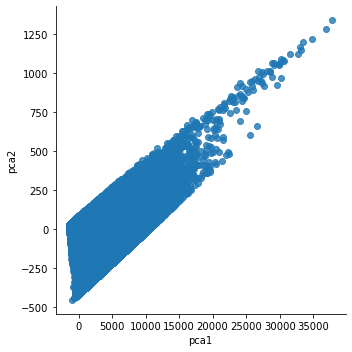

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
out_pca = pca.fit_transform(sess[['TOT_PAG_VIEW_CT',
                                'TOT_SESS_HR_V']])

data = out_pca
df_pca = pd.DataFrame(data, columns = ['pca1', 'pca2'])
print(df_pca.head())

#df_pca = pd.concat([df_pca,sess[['DVC_CTG_NM']]], axis=1)
#print(df_pca.head())
sns.lmplot(x="pca1", y="pca2", data=df_pca, fit_reg=False)

In [28]:
from sklearn import metrics
from sklearn import datasets
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5, algorithm='auto')
model.fit(df_pca)
predict = pd.DataFrame(model.predict(df_pca))
predict.columns=['predict']

out = pd.concat([df_pca,predict],axis=1)

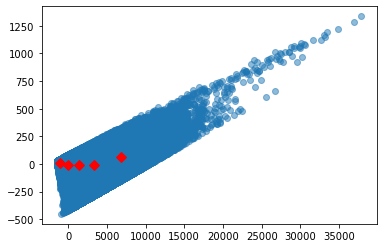

In [29]:
#new_sess = pd.DataFrame(sess, columns =sess[['TOT_PAG_VIEW_CT','TOT_SESS_HR_V']])
#sns.lmplot(x="TOT_PAG_VIEW_CT", y= "TOT_SESS_HR_V", data= sess[['TOT_PAG_VIEW_CT','TOT_SESS_HR_V']])

plt.scatter(df_pca['pca1'],df_pca['pca2'], alpha=0.5)
centers = pd.DataFrame(model.cluster_centers_, columns=['pca1','pca2'])
center_x = centers['pca1']
center_y = centers['pca2']
plt.scatter(center_x, center_y, s=50, marker='D', c='r')
plt.show()

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


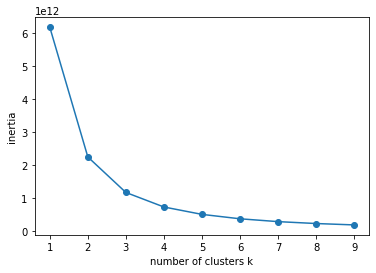

In [30]:

ks = range(1,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df_pca)
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [31]:
from sklearn.cluster import MiniBatchKMeans
clus = MiniBatchKMeans(n_clusters=5, batch_size=50, tol=0.004, max_iter=300)
clus.fit(df_pca)

MiniBatchKMeans(batch_size=50, max_iter=300, n_clusters=5, tol=0.004)

In [32]:
sns.lmplot(data=clus , x='pca1', y='pca2', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

TypeError: 'MiniBatchKMeans' object is not subscriptable

 ----탐색 과정에서의 시간
및 탐색 페이지의 수와 제품의 특성, 웹사이트의
특성이 제품 구매 결정과 구매를 결정했을 때의
구매 금액에 유의한 영향을 미침을 확인----

## 근데.. 
한 클라이언트가 방문한 세션 갯수와 페이지를 방문한 횟수, 머문 시간이 필요한건데..
흠...
각 세션별 페이지 조회 횟수와 머문시간 으로 해도 되것지?
이걸 또 같은 클라이언트일 경우로 묶어서 분석을 해야할까?
한 클라이언트가 방문하는 페이지 조회 횟수.. 



In [ ]:
#pandas의 corr() 을 사용해 상관계수 구하기
cor = sess.corr()

#seaborn의 히트맵을 사용한 시각화
sns.heatmap(cor, annot=False, cmap=plt.cm.Blues)
plt.show()

### 최적의 클러스터 개수 찾기 

In [48]:
from sklearn import metrics
from sklearn import datasets
from sklearn.cluster import KMeans
def make_blobs(X):
    n_samples = 1500
    blobs = datasets.make_blobs(n_samples=n_samples,
                               centers = 5,  # 센터의 개수 
                               cluster_std =[3.0, 0.9, 1.9, 1.9, 1.3], #클러스터내 데이터 포인트의 표준편차
                               random_state=51
                               )
    df = pd.DataFrame(blobs[0], columns=['Feature_1', 'Feature_2'])
    df.index.name = 'record'
    return df

df = make_blobs(sess)
n_clusters = [2,3,4,5,6,7,8,9]

for k in n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df)
    cluster_labels = kmeans.predict(df)
    S = metrics.silhouette_score(df, cluster_labels)
    print("n_Clusters = {:d}, silhouette score {:1f}".format(k,S))


n_Clusters = 2, silhouette score 0.442277
n_Clusters = 3, silhouette score 0.442798
n_Clusters = 4, silhouette score 0.513624
n_Clusters = 5, silhouette score 0.547875
n_Clusters = 6, silhouette score 0.524818
n_Clusters = 7, silhouette score 0.521323
n_Clusters = 8, silhouette score 0.488105
n_Clusters = 9, silhouette score 0.457069


In [ ]:
def elbow(X):
    sse = []
    for i in range(1,11):
        km = KMeans(n_clusters=i, init='k-means++', random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
    plt.plot(range(1,11), sse, markers='o')
    plt.xlabel('클러스터 개수')
    plt.ylabel('SSE')
    plt.show()
    
elbow(df_pca)

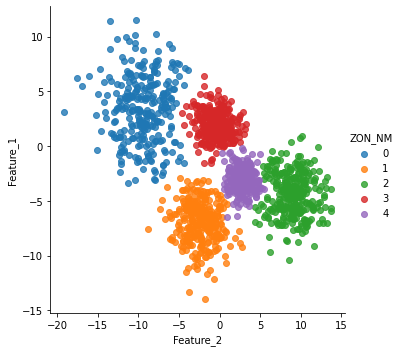

In [43]:
df = make_blobs()

from sklearn.cluster import AgglomerativeClustering
clus = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')

clus.fit(df)

df['ZON_NM'] = clus.labels_

sns.lmplot(x='Feature_2', y='Feature_1', hue="ZON_NM", data=df, fit_reg=False)

In [ ]:

from sklearn.cluster import MiniBatchKMeans
clus = MiniBatchKMeans(n_clusters=5, batch_size=50, tol=0.004, max_iter=300)
clus.fit(sess)
sns.lmplot(x='Feature_2', y='Feature_1', hue=" Cluster Labels", data=sess, fit_reg=False)